### Creating a SQL pipeline to query efficiently different tables on .csv files

Spreadsheets are frequently used in organizations for data analysis. Although Microsoft Excel and Google Sheets provide convenient user interfaces to manipulate data, they are not well suited to perform complex operations on large datasets. Even in small datasets, using more than one sheet and file to source data for a report can be error prone, particularly if these files are frequently edited. 

In this notebook, we provide a local database approach to manipulate and analyze data stored in different .csv files using SQL queries. In particular, we illustrate how SELECT, JOIN and COUNT statements can be applied to quickly obtain useful summary tables to report based in different user needs. The python packages required to execute this notebook are `pandas` and `sqlite3`.

In [1]:
# Import packages
import pandas as pd
import sqlite3

*Use case:*

An education administrator in an international school is looking at the student demographic data and course performance. The administrator went to an SQL workshop and decided to split a terribly large spreadsheet into three, simple and atomic tables:

* students: contains the student identifier `student_id`, and the `Name` and `Surname` of each student.
* students_details: contains students demographic data: `Gender` and `Country` of origin
* students_grades: contains the grades obtained by the students in different subjects.

In [2]:
# First we import the existing .csv files using pandas
# Note that we pass the optional parameter index_col = "student_id" to immediately assign the column
# as the dataframe index. This provide a neater dataframe.
df_students = pd.read_csv("students.csv", index_col="student_id")
df_details = pd.read_csv("students_details.csv", index_col="student_id")
df_grades = pd.read_csv("students_grades.csv", index_col="student_id")

We explore both datasets

In [3]:
df_students.head()

Name   Surname
student_id                  
0             Karl     Smith
1             John     Jones
2           Susane  Williams
3           Sophie    Taylor
4              Joe    Davies

In [4]:
df_details.head()

Gender Country
student_id               
0               M      UK
1               M     USA
2               F      UK
3               F  Poland
4               M   Spain

In [5]:
df_grades.head()

Maths English History Arts
student_id                           
0              A       B       B    A
1              A       A       C    C
2              A       A       B    C
3              B       A       B    B
4              C       C       A    A

We note that all these datasets have the `student_id` name as their primary key. 

Can we create a database to contain these three tables so QUERYING the database directly can provide more value than operating directly in excel?

The answer is YES! We just have to create a new database using `sqlite3.connect`, and then write the tables to the database using the function `pandas.DataFrame.to_sql`.

In [6]:
# Create a connection
conn = sqlite3.connect("students.db")

We use the df.to_sql function to create the tables on the empty database. We pass the name of the table as the first parameter, and the connection as the second parameter. Additionally, we are providing the additional parameter `if_exists="replace"`, which will replace the table with the dataframe every time the code below is ran.

In [7]:
# We specify the if_exists="replace" optional parameter to replace the table if already exists
df_students.to_sql("students", conn, if_exists="replace")
df_details.to_sql("details", conn,  if_exists="replace")
df_grades.to_sql("grades", conn, if_exists="replace")

Confirm that our database has all the tables required using a "special" query of SQLite 3 to retrieve all the table names in our database.

In [8]:
pd.read_sql_query( """
SELECT name FROM sqlite_master
WHERE type='table'
ORDER BY name
""", conn)

name
0   details
1    grades
2  students

Look at the students table

In [9]:
pd.read_sql_query("""
SELECT * 
FROM students
""", conn)

student_id    Name   Surname
0           0    Karl     Smith
1           1    John     Jones
2           2  Susane  Williams
3           3  Sophie    Taylor
4           4     Joe    Davies

### More interesting SQL queries on our newly created database

#### 1. Join all the tables with all their fields in a single query

In [10]:
pd.read_sql_query("""
SELECT s.student_id, s.Name, s.Surname, 
    d.Gender, d.Country, g.Maths, g.English, g.History, g.Arts
FROM students s
INNER JOIN details d
ON s.student_id=d.student_id
INNER JOIN grades g
ON s.student_id=g.student_id
""", conn)

student_id    Name   Surname Gender Country Maths English History Arts
0           0    Karl     Smith      M      UK     A       B       B    A
1           1    John     Jones      M     USA     A       A       C    C
2           2  Susane  Williams      F      UK     A       A       B    C
3           3  Sophie    Taylor      F  Poland     B       A       B    B
4           4     Joe    Davies      M   Spain     C       C       A    A

#### 2. Examine the number of students per country using the aggregate function COUNT

In [11]:
stud_num_df = pd.read_sql_query("""
SELECT d.country, COUNT(s.Name) as number_of_students
FROM students s
INNER JOIN details d
ON s.student_id=d.student_id
GROUP BY d.country
ORDER BY number_of_students DESC
""", conn)
stud_num_df.head()

Country  number_of_students
0      UK                   2
1     USA                   1
2   Spain                   1
3  Poland                   1

Use `pandas.plot.bar` to create a barplot on the resulting dataframe

Matplotlib is building the font cache; this may take a moment.


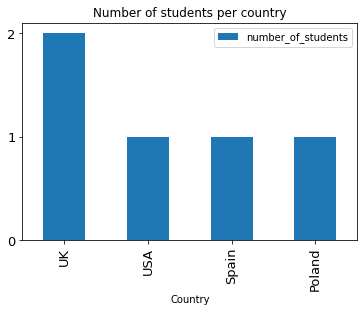

In [12]:
# Create a barplot with custom options to observe the distributions of students per country
ax = stud_num_df.plot.bar(x='Country',y='number_of_students', 
                          fontsize=13, yticks = [0,1,2], 
                         title = "Number of students per country")